In [14]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import PolynomialFeatures, StandardScaler
from sklearn.linear_model import LinearRegression
import torch
import torch.nn as nn
import torch.optim as optim
import copy  # For deepcopy
import math

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# -------------------------------
# Helper Functions for Aggregation
# -------------------------------

def aggregate_data_nosort(X, y, group_size):
    """
    Aggregate the data by grouping contiguous rows (without any pre-sorting)
    into groups of size 'group_size' and taking the mean over each group.
    Any remainder (if total samples is not divisible by group_size) is dropped.
    """
    n_groups = X.shape[0] // group_size
    if n_groups < 1:
        return X, y
    X_cut = X[:n_groups * group_size]
    y_cut = y[:n_groups * group_size]
    X_agg = X_cut.reshape(n_groups, group_size, X.shape[1]).mean(axis=1)
    y_agg = y_cut.reshape(n_groups, group_size).mean(axis=1)
    return X_agg, y_agg

def aggregate_X(X, group_size):
    """
    Aggregate only the features X by grouping rows in order into batches of size group_size.
    Returns the aggregated X (with shape [n_groups, features]) and the number of groups.
    """
    n_groups = X.shape[0] // group_size
    if n_groups < 1:
        return X, None
    X_cut = X[:n_groups * group_size]
    X_agg = X_cut.reshape(n_groups, group_size, X.shape[1]).mean(axis=1)
    return X_agg, n_groups

def replicate_aggregated_predictions(agg_preds, group_size, total):
    """
    Given aggregated predictions (one per group) and the original group_size,
    replicate each group prediction 'group_size' times to produce a vector of length total.
    If there is any remainder (i.e. total is not divisible by group_size),
    fill those with the last aggregated prediction.
    """
    preds = np.repeat(agg_preds, group_size)
    if preds.shape[0] < total:
        remainder = total - preds.shape[0]
        preds = np.concatenate([preds, np.full(remainder, agg_preds[-1])])
    return preds

def compute_group_size(t_frac, N, num_steps):
    """
    Given the time fraction (t/num_steps), number of samples N, and total number of time steps,
    determine the group size for aggregation.
      - At t=0 (t_frac==0): group all N paths (one datapoint).
      - At t=T (t_frac==1): no aggregation (group_size=1).
      - For very early nonzero times (e.g. the first nonzero time step), force grouping into 2 batches.
      - Otherwise, use an exponential rule.
    """
    if t_frac == 0:
        return N  # aggregate all paths into one datapoint
    if t_frac >= 1:
        return 1  # no aggregation
    min_nonzero = 1 / num_steps
    if t_frac <= min_nonzero + 1e-8:
        return N // 2
    candidate = 2 ** (math.floor(math.log2(1 / t_frac)) + 1)
    return candidate

# -------------------------------
# Main Classes
# -------------------------------

class BlackScholesMC:
    def __init__(self, S0, K, r, sigma, T, num_paths, num_steps, seed=None):
        self.S0, self.K, self.r, self.sigma, self.T = S0, K, r, sigma, T
        self.num_paths, self.num_steps = num_paths, num_steps
        self.dt = T / num_steps
        self.discount_factors = np.exp(-r * self.dt)
        self.seed = seed

    def simulate_paths(self):
        if self.seed is not None:
            np.random.seed(self.seed)
        S = np.zeros((self.num_paths, self.num_steps + 1))
        S[:, 0] = self.S0
        for t in range(1, self.num_steps + 1):
            Z = np.random.randn(self.num_paths)
            S[:, t] = S[:, t - 1] * np.exp(
                (self.r - 0.5 * self.sigma ** 2) * self.dt + self.sigma * np.sqrt(self.dt) * Z
            )
        return S

    def payoff(self, S):
        return np.maximum(S[:, -1] - self.K, 0)

class PolynomialRegressor:
    def __init__(self, degree=2):
        self.degree = degree
        self.poly = PolynomialFeatures(degree)
        self.model = LinearRegression()

    def fit(self, X, y):
        # Use full feature vector (state and time)
        X_poly = self.poly.fit_transform(X)
        self.model.fit(X_poly, y)

    def predict(self, X):
        X_poly = self.poly.transform(X)
        return self.model.predict(X_poly).squeeze()


# -------------------------------
# New Local Regression Regressor (LOESS)
# -------------------------------

class LocalRegressor:
    def __init__(self, bandwidth=None):
        self.bandwidth = bandwidth

    def fit(self, X, y):
        # Use only the state variable (first column) for local regression.
        self.X_train = X[:, 0]
        self.y_train = y
        if self.bandwidth is None:
            # A simple heuristic: 10% of the range of S values.
            self.bandwidth = 0.1 * (np.max(self.X_train) - np.min(self.X_train))

    def predict(self, X):
        S_test = X[:, 0]
        y_pred = np.empty(len(S_test))
        for i, s in enumerate(S_test):
            # Gaussian kernel weights based on the distance in S.
            weights = np.exp(-((s - self.X_train)**2) / (2 * self.bandwidth**2))
            if weights.sum() == 0:
                y_pred[i] = np.mean(self.y_train)
            else:
                y_pred[i] = np.sum(weights * self.y_train) / np.sum(weights)
        return y_pred


class FullyConnectedNN(nn.Module):
    def __init__(self, input_dim=2, hidden_dim=64, output_dim=1):
        super().__init__()
        # Added dropout and reduced hidden_dim for better regularization
        self.model = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, output_dim)
        ).to(device)
        self.constant = False
        self.num_steps = None  # to be set by ExposureCalculator later

    def fit(self, X, y, epochs=2000, lr=0.005):
        # Aggregation is used here for training.
        # Expect X[:,1] to be the time fraction.
        t_frac = X[0, 1]
        N = X.shape[0]
        num_steps = self.num_steps if self.num_steps is not None else 50
        group_size = compute_group_size(t_frac, N, num_steps)
        if group_size > 1:
            idx = np.argsort(X[:, 0])
            X_sorted = X[idx]
            y_sorted = y[idx]
            X_sorted, y_sorted = aggregate_data_nosort(X_sorted, y_sorted, group_size)
            if X_sorted.shape[0] == 1:
                self.constant = True
                self.constant_value = y_sorted[0]
                return
        else:
            X_sorted, y_sorted = X, y

        self.constant = False
        scaler = StandardScaler()
        X_scaled = scaler.fit_transform(X_sorted)
        y_scaled = np.log1p(y_sorted)

        X_tensor = torch.FloatTensor(X_scaled).to(device)
        y_tensor = torch.FloatTensor(y_scaled).unsqueeze(1).to(device)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.MSELoss()

        for _ in range(epochs):
            optimizer.zero_grad()
            loss = criterion(self.model(X_tensor), y_tensor)
            loss.backward()
            optimizer.step()
            scheduler.step()

        self.scaler = scaler

    def predict(self, X):
        # In prediction, we do NOT use aggregation.
        if self.constant:
            return np.full((X.shape[0],), self.constant_value)
        X_scaled = self.scaler.transform(X)
        with torch.no_grad():
            pred = self.model(torch.FloatTensor(X_scaled).to(device)).cpu().numpy()
        return np.expm1(pred).squeeze()


class CNNRegressor(nn.Module):
    def __init__(self, in_channels=2, kernel_size=3, dropout=0.2):
        super().__init__()
        self.conv1 = nn.Conv1d(in_channels, 64, kernel_size, padding=kernel_size//2)
        self.relu1 = nn.ReLU()
        self.dropout1 = nn.Dropout(dropout)
        self.conv2 = nn.Conv1d(64, 64, kernel_size, padding=kernel_size//2)
        self.relu2 = nn.ReLU()
        self.dropout2 = nn.Dropout(dropout)
        self.conv3 = nn.Conv1d(64, 32, kernel_size, padding=kernel_size//2)
        self.relu3 = nn.ReLU()
        self.dropout3 = nn.Dropout(dropout)
        self.fc = nn.Linear(32, 1)  # Applied on each element in the sequence.
        self.to(device)
        self.constant = False
        self.num_steps = None  # to be set externally

    def forward(self, x):
        # x shape: (batch_size, channels, seq_length)
        x = self.conv1(x)
        x = self.relu1(x)
        x = self.dropout1(x)
        x = self.conv2(x)
        x = self.relu2(x)
        x = self.dropout2(x)
        x = self.conv3(x)
        x = self.relu3(x)
        x = self.dropout3(x)
        # Permute to (batch_size, seq_length, features) and apply fc to each time step.
        x = x.permute(0, 2, 1)
        out = self.fc(x)  # shape: (batch_size, seq_length, 1)
        return out

    def fit(self, X, y, epochs=1000, lr=0.005):
        if np.std(X[:, 0]) < 1e-8:
            self.constant = True
            self.constant_value = np.mean(y)
            return

        # --- Aggregation Preprocessing for CNN ---
        # For CNN we aggregate without pre-sorting the original data.
        t_frac = X[0, 1]
        N = X.shape[0]
        num_steps = self.num_steps if self.num_steps is not None else 50
        group_size = compute_group_size(t_frac, N, num_steps)
        if group_size > 1:
            X_agg, y_agg = aggregate_data_nosort(X, y, group_size)
            # Now sort the aggregated data by the aggregated stock price (first column)
            sort_idx = np.argsort(X_agg[:, 0])
            X_sorted = X_agg[sort_idx]
            y_sorted = y_agg[sort_idx]
            if X_sorted.shape[0] == 1:
                self.constant = True
                self.constant_value = y_sorted[0]
                return
        else:
            X_sorted, y_sorted = X, y

        self.constant = False
        self.scaler = StandardScaler()
        X_scaled = self.scaler.fit_transform(X_sorted)  # shape: (n_samples, 2)
        # Reshape X to (batch_size=1, channels=2, seq_length=n_samples)
        X_tensor = torch.FloatTensor(X_scaled.T).unsqueeze(0).to(device)
        y_transformed = np.log1p(y_sorted)
        y_tensor = torch.FloatTensor(y_transformed).unsqueeze(0).unsqueeze(2).to(device)

        optimizer = optim.AdamW(self.parameters(), lr=lr, weight_decay=1e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
        criterion = nn.MSELoss()
        self.train()
        for _ in range(epochs):
            optimizer.zero_grad()
            output = self.forward(X_tensor)
            loss = criterion(output, y_tensor)
            loss.backward()
            optimizer.step()
            scheduler.step()
        self.eval()

    def predict(self, X):
        if self.constant:
            return np.full((X.shape[0],), self.constant_value)
        t_frac = X[0, 1]
        N = X.shape[0]
        group_size = compute_group_size(t_frac, N, self.num_steps if self.num_steps is not None else 50)
        if group_size > 1:
            # Aggregate test data (without pre-sorting)
            X_agg, _ = aggregate_X(X, group_size)
            # Now sort the aggregated data by aggregated state (first column)
            sort_idx = np.argsort(X_agg[:, 0])
            X_agg_sorted = X_agg[sort_idx]
            X_scaled = self.scaler.transform(X_agg_sorted)
            X_tensor = torch.FloatTensor(X_scaled.T).unsqueeze(0).to(device)
            with torch.no_grad():
                output = self.forward(X_tensor)
            agg_preds_sorted = np.expm1(output.cpu().numpy().squeeze())
            # Unsort the aggregated predictions to match original grouping order.
            unsort_idx = np.argsort(sort_idx)
            agg_preds = agg_preds_sorted[unsort_idx]
            y_pred = replicate_aggregated_predictions(agg_preds, group_size, X.shape[0])
            return y_pred
        else:
            # If no aggregation is used, sort test data by state variable for prediction.
            sorted_idx = np.argsort(X[:, 0])
            X_sorted = X[sorted_idx]
            X_scaled = self.scaler.transform(X_sorted)
            X_tensor = torch.FloatTensor(X_scaled.T).unsqueeze(0).to(device)
            with torch.no_grad():
                output = self.forward(X_tensor)
            y_pred_sorted = np.expm1(output.cpu().numpy().squeeze())
            y_pred = np.zeros_like(y_pred_sorted)
            y_pred[sorted_idx] = y_pred_sorted
            return y_pred

class ExposureCalculator:
    def __init__(self, mc_engine_1st, mc_engine_2nd, regressor):
        self.mc_engine_1st = mc_engine_1st
        self.mc_engine_2nd = mc_engine_2nd
        self.regressor = regressor
        self.regressors = {}

    def first_pass(self):
        S = self.mc_engine_1st.simulate_paths()
        option_payoff = self.mc_engine_1st.payoff(S)
        pathwise_exposure = np.zeros((self.mc_engine_1st.num_paths, self.mc_engine_1st.num_steps + 1))
        pathwise_exposure[:, -1] = option_payoff
        for t in range(self.mc_engine_1st.num_steps - 1, -1, -1):
            pathwise_exposure[:, t] = pathwise_exposure[:, t + 1] * self.mc_engine_1st.discount_factors
            t_feature = np.full((self.mc_engine_1st.num_paths, 1), t / self.mc_engine_1st.num_steps)
            X_train = np.hstack((S[:, t].reshape(-1, 1), t_feature))
            # Use deepcopy to preserve regressor settings.
            self.regressors[t] = copy.deepcopy(self.regressor)
            if isinstance(self.regressors[t], (FullyConnectedNN, CNNRegressor)):
                self.regressors[t].num_steps = self.mc_engine_1st.num_steps
            self.regressors[t].fit(X_train, pathwise_exposure[:, t])

    def second_pass(self):
        if not self.regressors:
            raise ValueError("first_pass() must be run before second_pass()!")
        S = self.mc_engine_2nd.simulate_paths()
        estimated_exposure = np.zeros((self.mc_engine_2nd.num_paths, self.mc_engine_2nd.num_steps + 1))
        for t in range(self.mc_engine_2nd.num_steps):
            t_feature = np.full((self.mc_engine_2nd.num_paths, 1), t / self.mc_engine_2nd.num_steps)
            X_test = np.hstack((S[:, t].reshape(-1, 1), t_feature))
            if t not in self.regressors:
                raise KeyError(f"Regressor for t={t} not found. Make sure first_pass() was executed.")
            estimated_exposure[:, t] = self.regressors[t].predict(X_test).squeeze()
        estimated_exposure[:, self.mc_engine_2nd.num_steps] = self.mc_engine_2nd.payoff(S)
        EPE = np.mean(np.maximum(estimated_exposure, 0), axis=0)
        ENE = np.mean(np.minimum(estimated_exposure, 0), axis=0)
        return EPE, ENE

if __name__ == "__main__":
    S0, K, r, sigma, T = 140, 140, 0.02, 0.2, 5
    num_paths_1st, num_paths_2nd, num_steps = 5000, 20000, 50
    seed_1st, seed_2nd = 42, 99

    mc_engine_1st = BlackScholesMC(S0, K, r, sigma, T, num_paths_1st, num_steps, seed_1st)
    mc_engine_2nd = BlackScholesMC(S0, K, r, sigma, T, num_paths_2nd, num_steps, seed_2nd)

    regressors = {
        "Polynomial (Degree 2)": PolynomialRegressor(degree=2),
        "Polynomial (Degree 3)": PolynomialRegressor(degree=3),
        "Local Regression": LocalRegressor(),  # (LocalRegression remains as before.)
        # "Fully Connected NN": FullyConnectedNN(),
        "CNN Regressor": CNNRegressor()  # Uncomment to use the CNN-based regressor.
    }

    results = {}
    for name, reg in regressors.items():
        print(f"Processing {name} on {device}...")
        exposure_calc = ExposureCalculator(mc_engine_1st, mc_engine_2nd, reg)
        exposure_calc.first_pass()  # Must call first_pass() before second_pass()
        results[name] = exposure_calc.second_pass()

Using device: cuda
Processing Polynomial (Degree 2) on cuda...
Processing Polynomial (Degree 3) on cuda...
Processing Local Regression on cuda...


/tmp/ipykernel_7277/1190941295.py:222: RuntimeWarning: invalid value encountered in divide
  weights = np.exp(-((s - self.X_train)**2) / (2 * self.bandwidth**2))


Processing CNN Regressor on cuda...


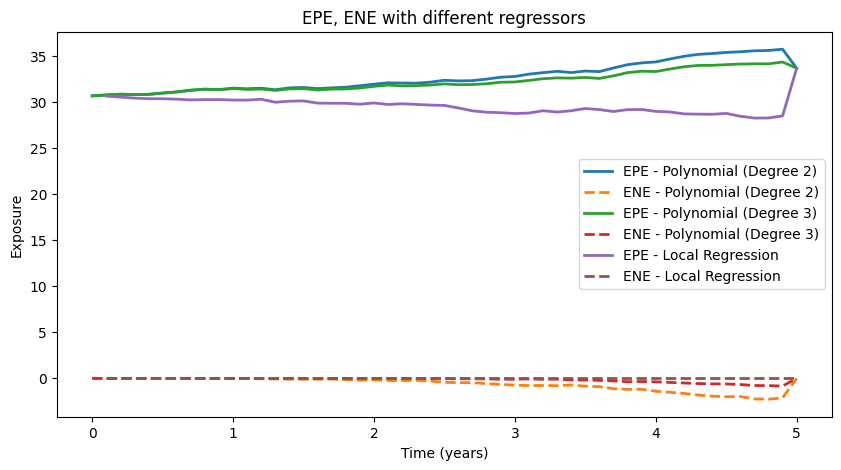

In [17]:
    results = {k: v for k, v in results.items() if k != "CNN Regressor"}
    plt.figure(figsize=(10, 5))
    for name, (EPE, ENE) in results.items():
        plt.plot(np.linspace(0, T, num_steps + 1), EPE, label=f"EPE - {name}", linewidth=2)
        plt.plot(np.linspace(0, T, num_steps + 1), ENE, linestyle="--", label=f"ENE - {name}", linewidth=2)

    plt.title("EPE, ENE with different regressors")
    plt.xlabel("Time (years)")
    plt.ylabel("Exposure")
    plt.legend()
    plt.show()